In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cv2 as cv

import findatree.io as io
import findatree.segmentation as segment

importlib.reload(segment)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define raster-files and print infos

In [14]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_11626_D-20210719_DSM.tif'])
file_names.extend(['tnr_11626_dtm.tif'])
file_names.extend(['Tnr_11626_2021_Ortho.tif'])


paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

io.print_raster_info(paths)


(0)
Name: C:/Data/lwf/DSM_2021/Tnr_11626_D-20210719_DSM.tif
Width[px]: 5749
Height[px]: 5423
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-32767.0,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=742322.8121385165, bottom=5457550.352693843, right=742825.1654599565, top=5458024.21981198)
Affine geo-transfrom: [0.087380991727266, 0.0, 742322.8121385165, 0.0, -0.08738099172726485, 5458024.21981198]

(1)
Name: C:/Data/lwf/DTM/tnr_11626_dtm.tif
Width[px]: 461
Height[px]: 425
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-3.4028234663852886e+38,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=742354.9683434721, bottom=5457599.985097144, right=742815.9683434721, top=5458024.985097144)
Affine geo-transfrom: [1.0, 0.0, 742354.9683434721, 0.0, -1.0, 5458024.985097144]

(2)
Name: C:/Data/lwf/Orthophotos_2021/Tnr_11626_2021_Ortho.tif
Width[px]: 8236
Height[px]: 8815
No. of rasters: 5
  Index: 1, dtype: uint16
  I

### Reproject raster-files to same area & resolution

In [15]:
importlib.reload(io)
res = 0.25
bands, mask, A, bound = io.reproject_all_intersect(paths, res=res)

### Define and normalize channels

In [18]:
chm = (bands[0][:,:,0] - bands[1][:,:,0]).astype(np.float32)
blue = (bands[2][:,:,0] / (2**16 - 1)).astype(np.float32)
green = (bands[2][:,:,1] / (2**16 - 1)).astype(np.float32)
red = (bands[2][:,:,2] / (2**16 - 1)).astype(np.float32)
re = (bands[2][:,:,2] / (2**16 - 1)).astype(np.float32)
nir = (bands[2][:,:,4] / (2**16 - 1)).astype(np.float32)

ndvi = (nir - red) / (nir + red)

### Plotting of channels


(1000.0, 400.0)

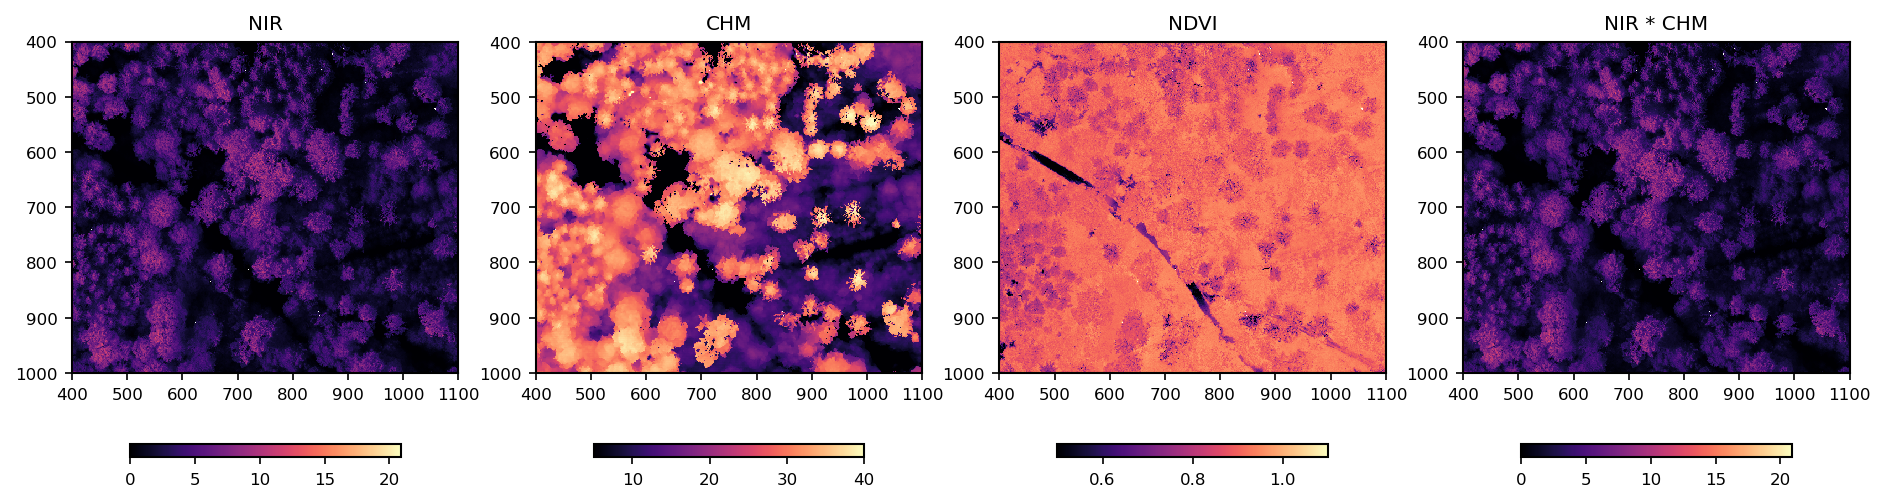

In [17]:
xlim = (400, 1100)
ylim = (1000, 400)
# xlim = (0, bands[0].shape[1])
# ylim = (bands[0].shape[0], 0)


########### Plotting
f, axs = plt.subplots(ncols=4, figsize=(15,4))
f.subplots_adjust(hspace=0.01)


##############################################
img = nir * chm

ax = axs[0]
mapp = ax.imshow(
    img,
    vmin=0, #np.nanmin(img.flatten()),
    vmax=np.nanmax(img.flatten()),
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('NIR')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##############################################
img = chm.copy()
ax = axs[1]
mapp = ax.imshow(
    img,
    vmin=5,
    vmax=40,
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('CHM')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##############################################
img = ndvi

ax = axs[2]
mapp = ax.imshow(
    img,
    vmin=0.5,
    vmax=1.1,
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('NDVI')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##############################################
def chm_activation(chm, hmin, hmax, actdiff):
    actmin = 1 - actdiff
    actmax = 1 + actdiff
    slope = (actmin - actmax) / (hmax - hmin)
    
    act = actmax + (chm - hmin) * slope
    
    act[chm < hmin] = 0
    act[chm > hmax] = actmin

    return act

img = nir * chm

ax = axs[3]
mapp = ax.imshow(
    img,
    vmin=0,
    vmax=np.nanmax(img.flatten()),
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('NIR * CHM')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

### Generate markers for marker-controlled watershed

In [56]:
##################### Define image used for creating markers for watershed
img_obj = chm * nir
img_obj[chm < 5] = np.nan
img_obj[ndvi < 0.5] = np.nan
img_obj -= np.nanmin(img_obj.flatten())
img_obj *= 255 / np.nanmax(img_obj.flatten())
img_obj = img_obj.astype(np.uint8)

##################### Median Blur
img_blur = cv.medianBlur(img_obj.astype(np.uint8), 3)
for i in range(10):
    img_blur = cv.medianBlur(img_blur.astype(np.uint8), 3)

##################### Gaussian adaptive thresholding -> mask
mask = cv.adaptiveThreshold(
    img_blur, 1, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv.THRESH_BINARY, 241, 0,
)

##################### Divide connected regions into sub-regions based on distance transform, this will be our sure foreground
sure_fg= mask.copy()
for i in range(10):
    sure_fg = segment.divide_connected_regions(sure_fg)

### Marker-controlled watershed on CHM

In [63]:
##################### Dilate inital mask to create a thiner, sure background
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
sure_bg = cv.dilate(mask, kernel, iterations=3)

##################### Dilate sure_fg a bit to get a better seed for the watershed
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
seed = cv.dilate(sure_fg, kernel, iterations=3)

##################### Unknow area 
unkown = sure_bg - seed

##################### Get connnected compontents of the seed
ret, markers = cv.connectedComponents(seed)

##################### Prepare final markers for watershedding, must be of dtype=np.uint32
# sure_bg -> 1
# unknown -> 0
# seed -> >=2
markers = markers + 1 - unkown
markers = markers.astype(np.int32)

##################### Prepare image for watershedding, must be of dtype=np.uint8 with shape (m,n,3)
img = np.zeros((nir.shape[0], nir.shape[1], 3), dtype=np.uint8)
for i in range(3): 
    img[:,:,i] = chm # Watershedding based on CHM yielded best result!

##################### Watershed
markers = cv.watershed(img, markers)

img_obj_vis = img_obj.copy()
img_obj_vis[markers == -1] = 255

### Plotting of segmentation results

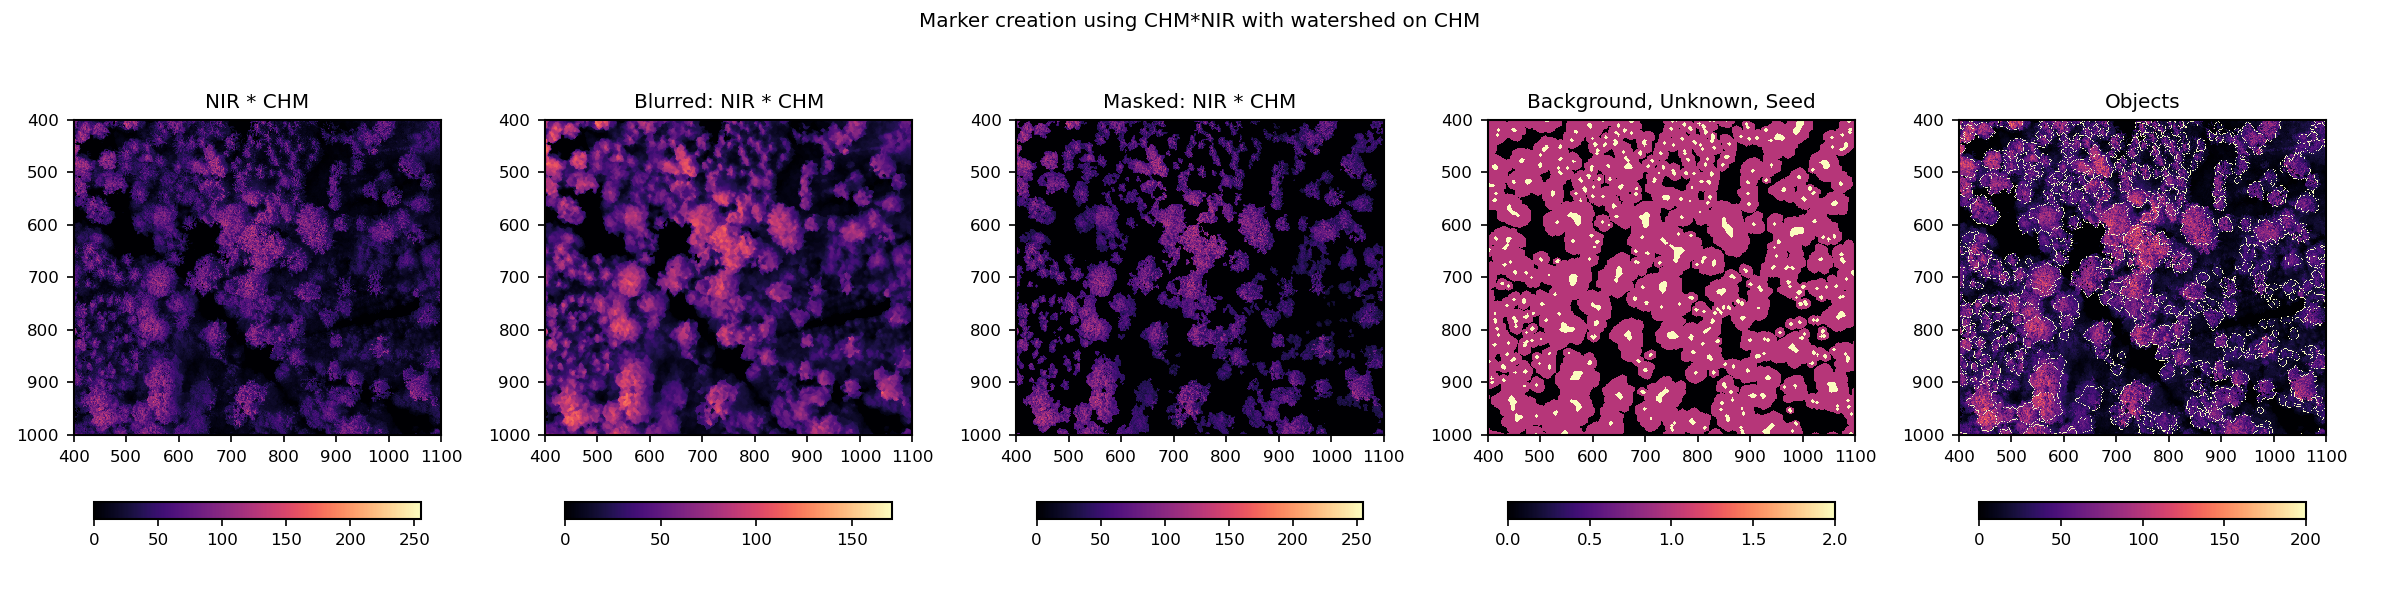

In [70]:
%matplotlib widget

f, axs = plt.subplots(ncols=5, figsize=(16, 4))
f.subplots_adjust(left=0.01, right=0.99, bottom=0.05, top=0.8, wspace=0.01)
f.suptitle('Marker creation using CHM*NIR with watershed on CHM')

############################################## 
ax = axs[0]
mapp = ax.imshow(
    img_obj,
    vmin=np.nanmin(img_obj.flatten()),
    vmax=np.nanmax(img_obj.flatten()),
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('NIR * CHM')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

############################################## 
ax = axs[1]
mapp = ax.imshow(
    img_blur,
    vmin=np.nanmin(img_blur.flatten()),
    vmax=np.nanmax(img_blur.flatten()),
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Blurred: NIR * CHM')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

############################################## 
ax = axs[2]
mapp = ax.imshow(
    mask * img_obj,
    # vmin=0,
    # vmax=1,
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Masked: NIR * CHM')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##############################################
ax = axs[3]
mapp = ax.imshow(
    sure_bg + seed,
    vmin=0,
    vmax=2,
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Background, Unknown, Seed')
ax.set_xlim(xlim)
_ = ax.set_ylim(ylim)

##############################################
ax = axs[4]
mapp = ax.imshow(
    img_obj_vis,
    vmin=0,
    vmax=200,
    cmap='magma',
)

plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Objects')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

f.savefig(r'C:\Users\flori\Desktop\objects_mark-NIR-CHM_water-CHM.pdf', transparent=True)

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
f.subplots_adjust(left=0.01, right=0.99, bottom=0.05, top=0.8, wspace=0.01)

mapp = ax.imshow(
    img_obj_vis,
    vmin=0,
    vmax=200,
    cmap='magma',
)

# plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Segmentation')

f.savefig(r'C:\Users\flori\Desktop\objects_mark-NIR-CHM_water-CHM_full.pdf', transparent=True)